In [1]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

from tqdm import tqdm
import numpy as np
import pandas as pd
!pip install text_hammer
import text_hammer as th
import seaborn as sns

import string
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from transformers import AutoTokenizer,TFBertModel

max_len = 36

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

from nltk.corpus import stopwords
from wordcloud import WordCloud

     |████████████████████████████████| 115 kB 21.4 MB/s            
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.10.0
    Uninstalling beautifulsoup4-4.10.0:
      Successfully uninstalled beautifulsoup4-4.10.0


In [2]:
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [3]:
df_train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
print('Размер обучающего набора данных = {}'.format(df_train.shape))
print('Объем памяти, используемый обучающим набором данных = {:.2f} МБ'.format(df_train.memory_usage().sum() / 1024**2))
print('Размер тестового набора данных = {}'.format(df_test.shape))
print('Объем памяти, используемый тестовым набором данных = {:.2f} МБ'.format(df_test.memory_usage().sum() / 1024**2))

Размер обучающего набора данных = (7613, 5)
Объем памяти, используемый обучающим набором данных = 0.29 МБ
Размер тестового набора данных = (3263, 4)
Объем памяти, используемый тестовым набором данных = 0.10 МБ


In [5]:
df_test['message_len'] = df_test['text'].apply(lambda x: len(x.split(' ')))
df_test.head(20)

,id,keyword,location,text,message_len
0,0,NaN,NaN,Just happened a terrible car crash,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8
5,12,NaN,NaN,We're shaking...It's an earthquake,4
6,21,NaN,NaN,They'd probably still show more life than Arse...,12
7,22,NaN,NaN,Hey! How are you?,4
8,27,NaN,NaN,What a nice hat?,4
9,29,NaN,NaN,Fuck off!,2


In [6]:
df_train['message_len'] = df_train['text'].apply(lambda x: len(x.split(' ')))
df_train.head(20)

,id,keyword,location,text,target,message_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,18
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,14
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,15
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,12
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,10


In [8]:
def text_preprocessing(df, col_name):
    column = col_name
    tqdm.pandas()
    df[column] = df[column].progress_apply(lambda x: str(x).lower()) \
                   .progress_apply(lambda x: th.remove_emails(x)) \
                   .progress_apply(lambda x: th.remove_html_tags(x)) \
                   .progress_apply(lambda x: th.remove_special_chars(x)) \
                   .progress_apply(lambda x: th.remove_accented_chars(x))
    return df

In [9]:
train_cleaned_data = text_preprocessing(df_train,'text')

100%|██████████| 7613/7613 [00:00<00:00, 277551.90it/s]


In [10]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

df_train['text'] = df_train['text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
df_train.head(20)

,id,keyword,location,text,target,message_len
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,13
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7
2,5,NaN,NaN,residents asked shelter place notified officer...,1,22
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,9
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,17
5,8,NaN,NaN,rockyfire update california hwy 20 closed dire...,1,18
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1,14
7,13,NaN,NaN,im top hill see fire woods,1,15
8,14,NaN,NaN,theres emergency evacuation happening building...,1,12
9,15,NaN,NaN,im afraid tornado coming area,1,10


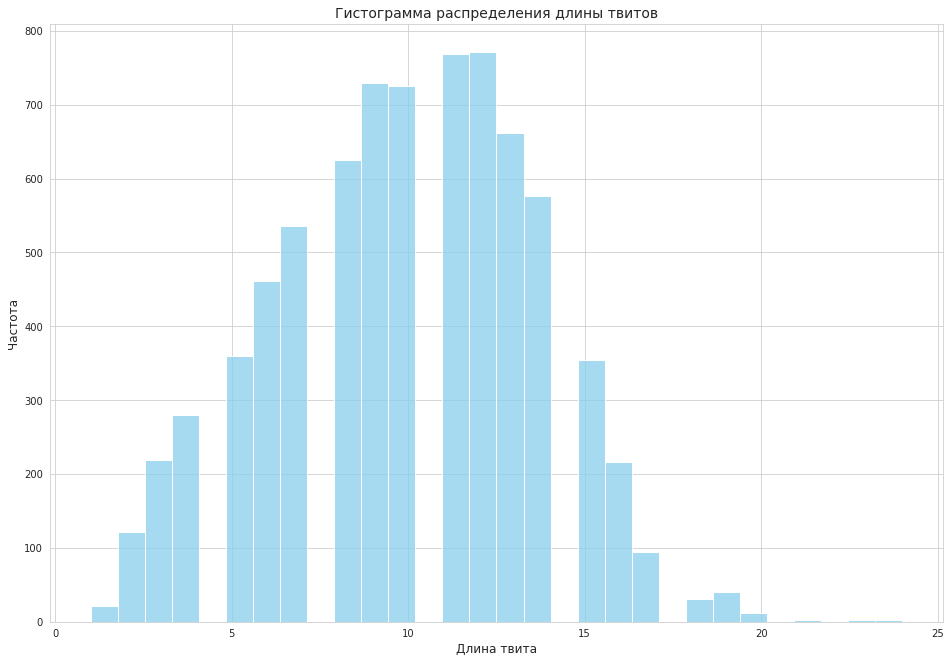

In [106]:
sns.set_style("whitegrid")

plt.figure(figsize=(16, 11))
sns.histplot(df_train['text'].apply(lambda x: len(x.split())), bins=30, color='skyblue')
plt.xlabel("Длина твита", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.title("Гистограмма распределения длины твитов", fontsize=14)
plt.show()

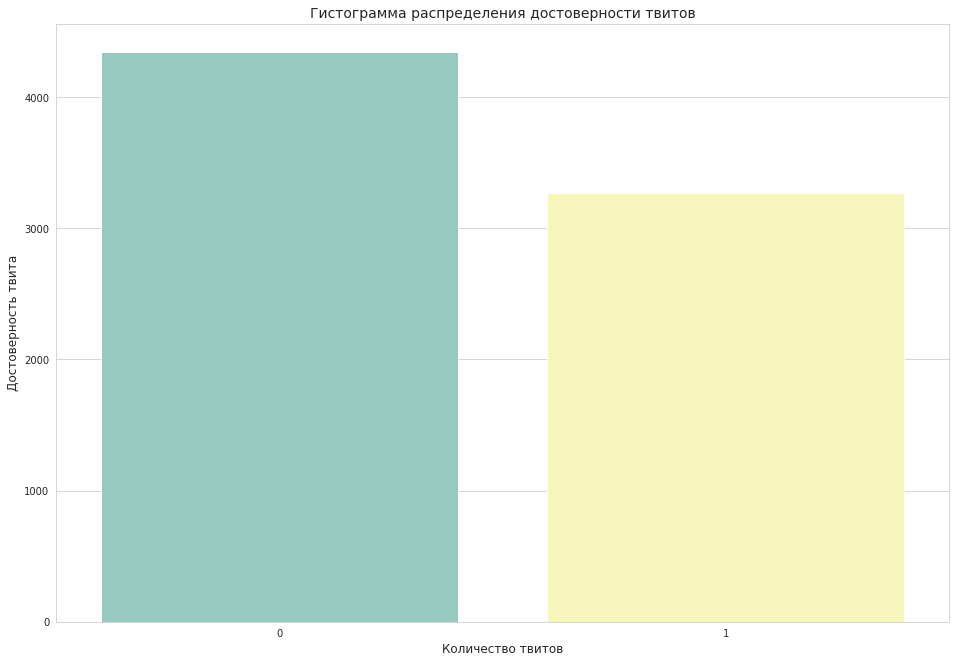

In [107]:
plt.figure(figsize=(16, 11))
sns.countplot(x='target', data=df_train, palette="Set3")
plt.xlabel("Количество твитов", fontsize=12)
plt.ylabel("Достоверность твита", fontsize=12)
plt.title("Гистограмма распределения достоверности твитов", fontsize=14)
plt.show()

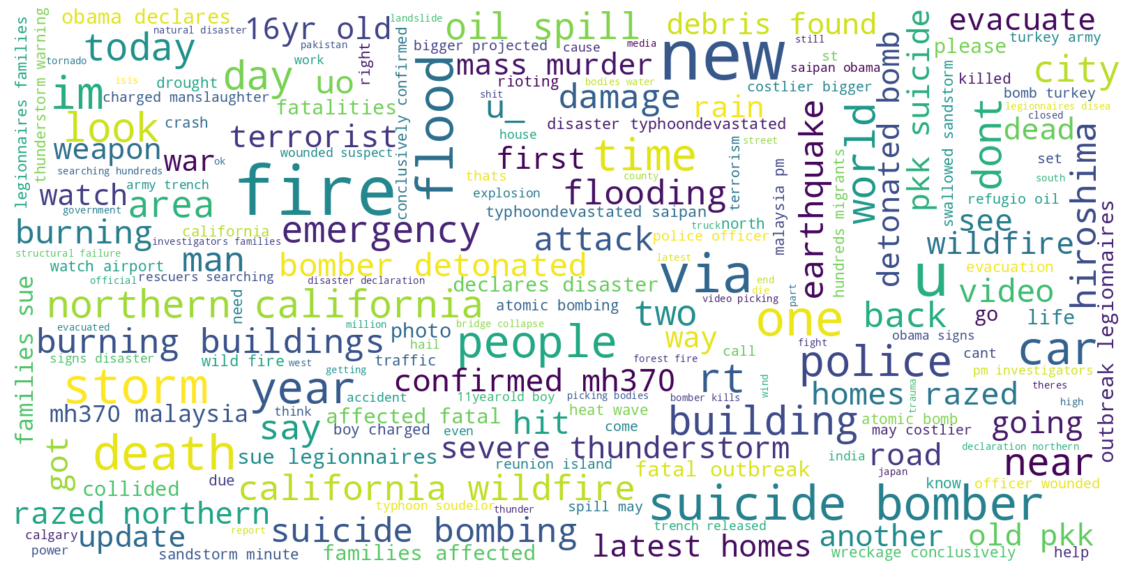

In [97]:
disaster_tweets = df_train[df_train.target == 1]['text']
disaster_string = ' '.join(disaster_tweets)
wordcloud = WordCloud(width=1600, height=800, max_font_size=100, background_color='white').generate(disaster_string)

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

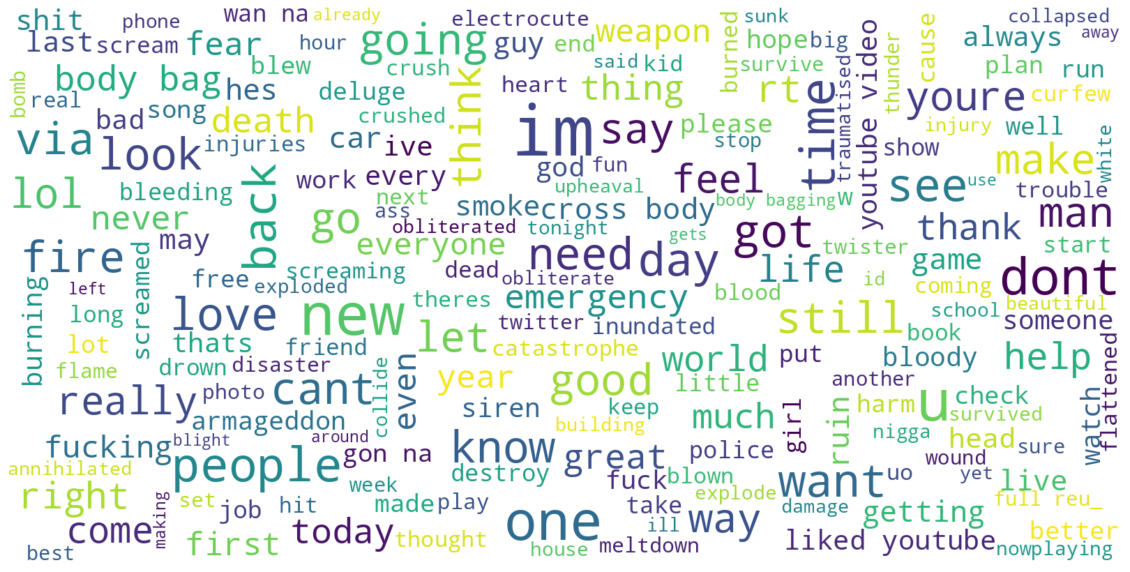

In [96]:
formal_tweets = df_train[df_train.target == 0]['text']
formal_string = ' '.join(formal_tweets)
wordcloud = WordCloud(width=1600, height=800, max_font_size=100, background_color='white').generate(formal_string)

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
def create_text_features(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
    df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

create_text_features(df_train)
create_text_features(df_test)


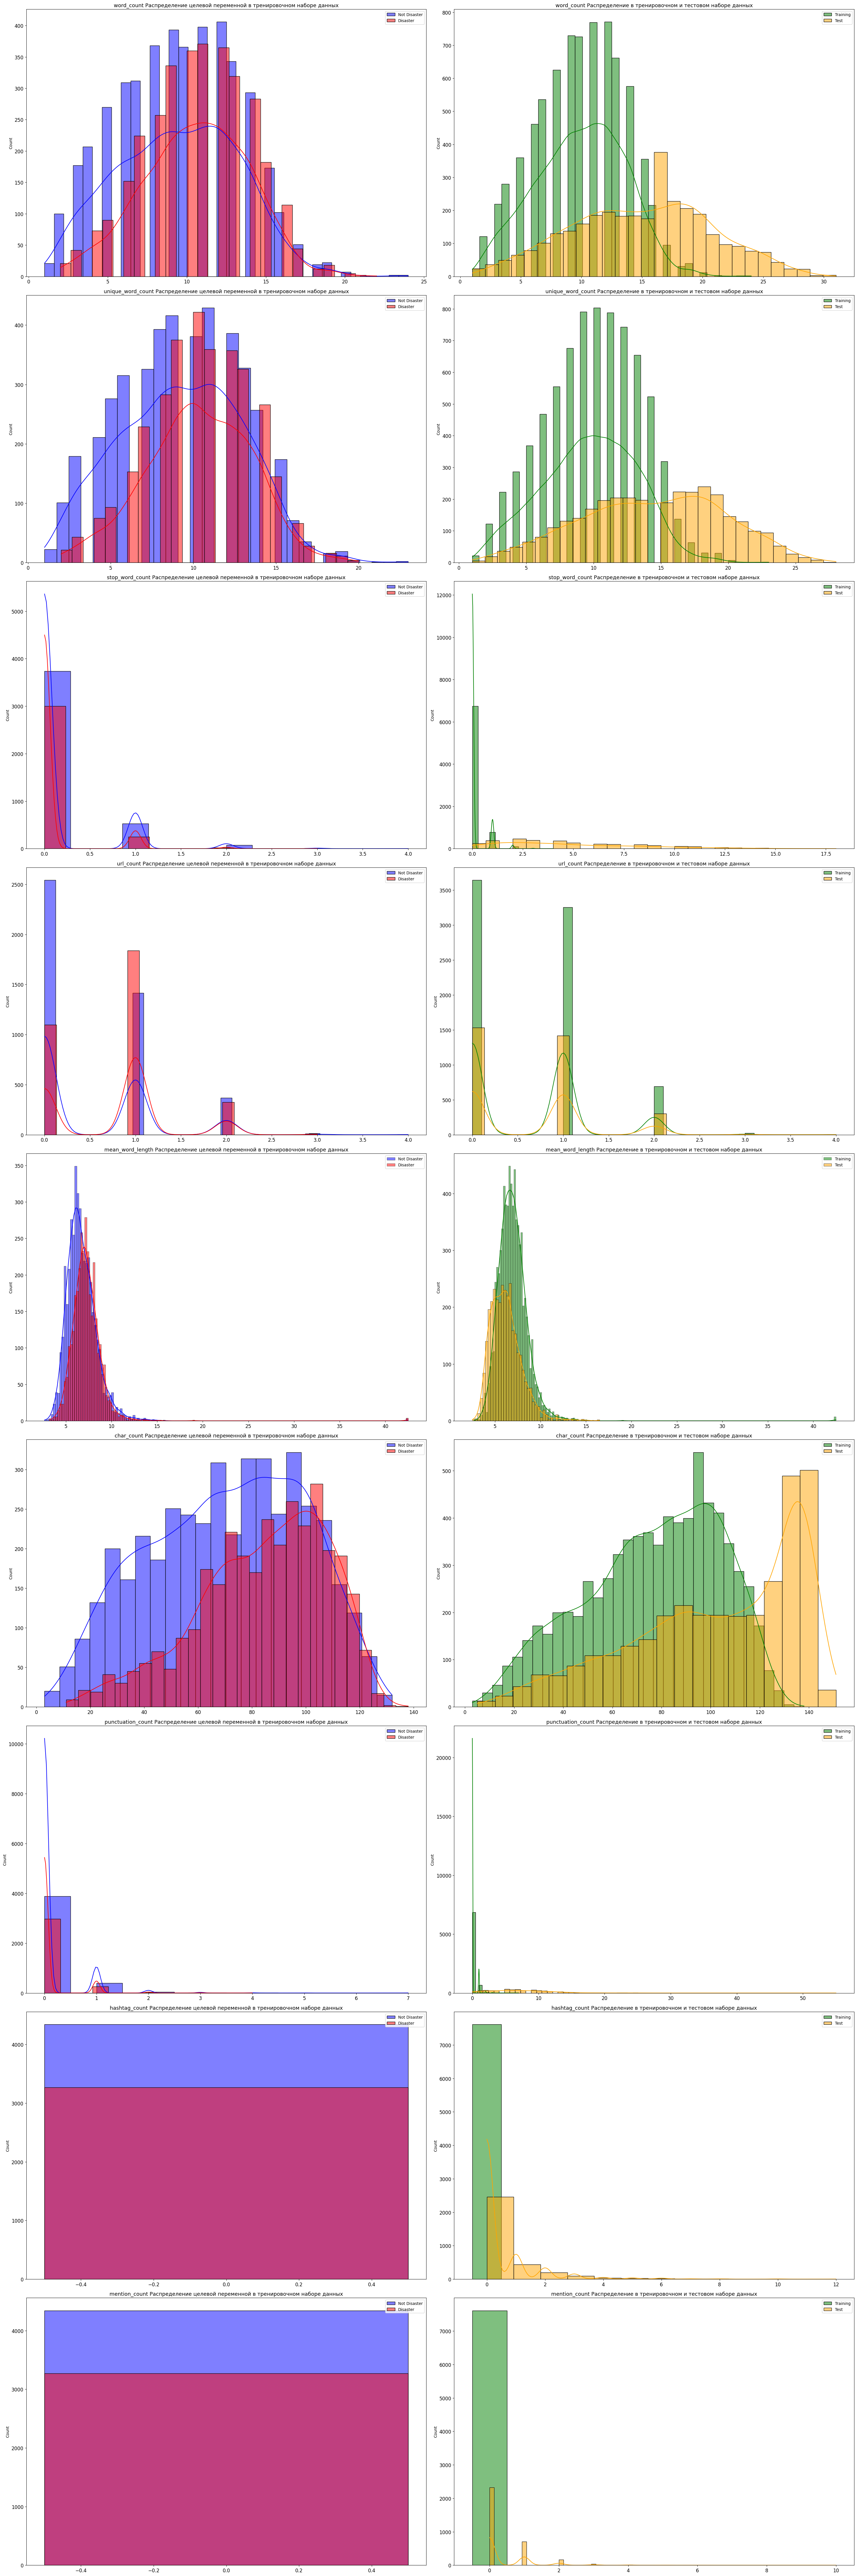

In [93]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(30, 90), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='blue', kde=True)
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red', kde=True)

    sns.histplot(df_train[feature], label='Training', ax=axes[i][1], color='green', kde=True)
    sns.histplot(df_test[feature], label='Test', ax=axes[i][1], color='orange', kde=True)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Распределение целевой переменной в тренировочном наборе данных', fontsize=13)
    axes[i][1].set_title(f'{feature} Распределение в тренировочном и тестовом наборе данных', fontsize=13)

plt.tight_layout()
plt.show()


In [90]:
from collections import Counter

def generate_ngrams(text, n_gram=1):
    tokens = [token for token in text.lower().split() if token != '' and token not in STOPWORDS]
    ngrams = zip(*[tokens[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

def count_ngrams(df, target, n_gram=1):
    ngrams_counter = Counter()
    for tweet in df[df['target'] == target]['text']:
        ngrams = generate_ngrams(tweet, n_gram)
        ngrams_counter.update(ngrams)
    return ngrams_counter

N = 50

disaster_unigrams_counter = count_ngrams(df_train, 1)
nondisaster_unigrams_counter = count_ngrams(df_train, 0)

df_disaster_unigrams = pd.DataFrame(disaster_unigrams_counter.most_common(N), columns=['Униграмма', 'Частота'])
df_nondisaster_unigrams = pd.DataFrame(nondisaster_unigrams_counter.most_common(N), columns=['Униграмма', 'Частота'])

disaster_bigrams_counter = count_ngrams(df_train, 1, n_gram=2)
nondisaster_bigrams_counter = count_ngrams(df_train, 0, n_gram=2)

df_disaster_bigrams = pd.DataFrame(disaster_bigrams_counter.most_common(N), columns=['Биграмма', 'Частота'])
df_nondisaster_bigrams = pd.DataFrame(nondisaster_bigrams_counter.most_common(N), columns=['Биграмма', 'Частота'])

disaster_trigrams_counter = count_ngrams(df_train, 1, n_gram=3)
nondisaster_trigrams_counter = count_ngrams(df_train, 0, n_gram=3)

df_disaster_trigrams = pd.DataFrame(disaster_trigrams_counter.most_common(N), columns=['Триграмма', 'Частота'])
df_nondisaster_trigrams = pd.DataFrame(nondisaster_trigrams_counter.most_common(N), columns=['Триграмма', 'Частота'])

print("Униграммы катастрофических твитов:")
print(df_disaster_unigrams)
print('*'*40)
print("\nУниграммы не-катастрофических твитов:")
print(df_nondisaster_unigrams)
print('-'*40)
print("\nБиграммы катастрофических твитов:")
print(df_disaster_bigrams)
print('*'*40)
print("\nБиграммы не-катастрофических твитов:")
print(df_nondisaster_bigrams)
print('-'*40)
print("\nТриграммы катастрофических твитов:")
print(df_disaster_trigrams)
print('*'*40)
print("\nТриграммы не-катастрофических твитов:")
print(df_nondisaster_trigrams)


Униграммы катастрофических твитов:
       Униграмма  Частота
0           fire      177
1           news      132
2            via      121
3       disaster      117
4     california      111
5        suicide      110
6         police      106
7         people      105
8         killed       93
9      hiroshima       84
10         fires       83
11         crash       82
12         storm       82
13            us       81
14      families       81
15         train       79
16     emergency       75
17             2       73
18          bomb       73
19     buildings       73
20           two       71
21         mh370       71
22       nuclear       70
23      wildfire       69
24        attack       68
25         video       68
26      accident       66
27           one       65
28       bombing       65
29      northern       64
30       burning       64
31            pm       62
32  legionnaires       62
33          dead       61
34        bomber       60
35         homes       58
36 

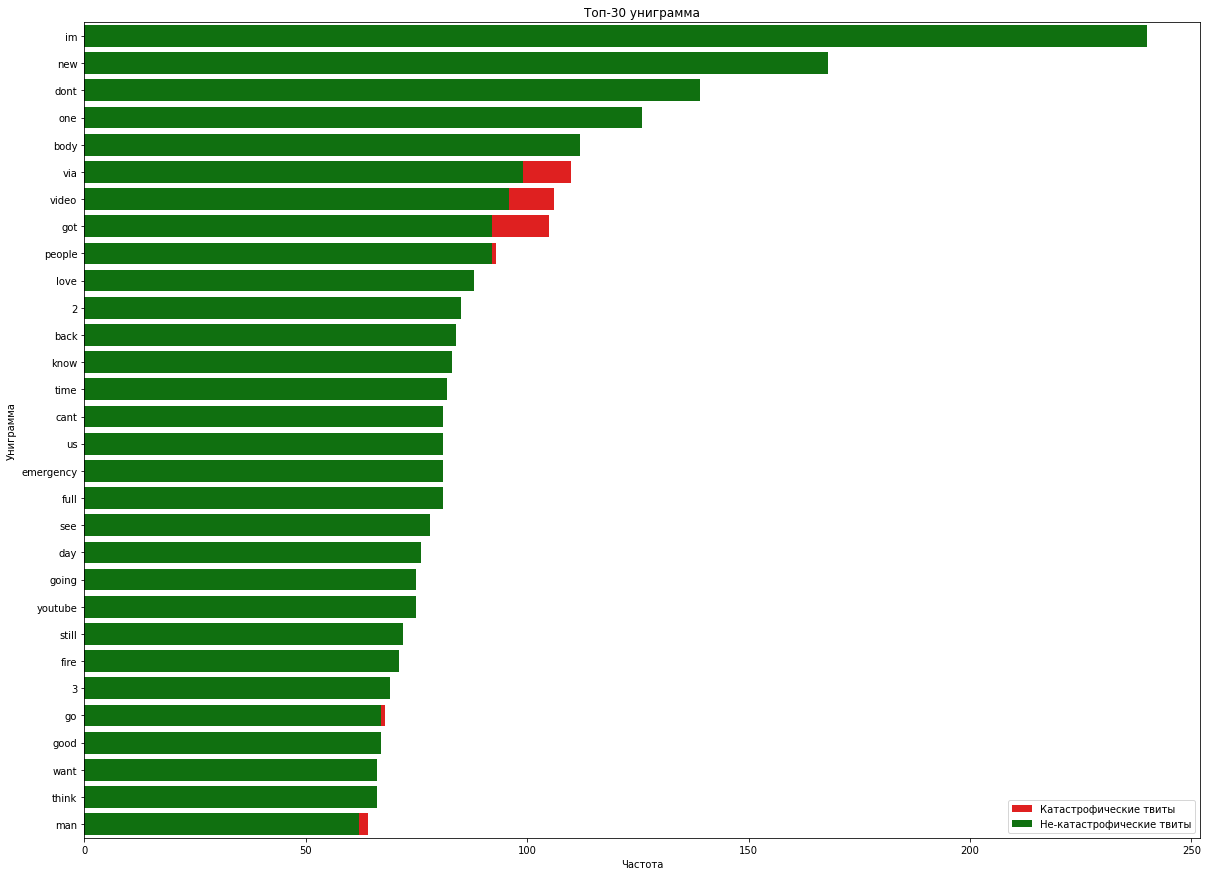

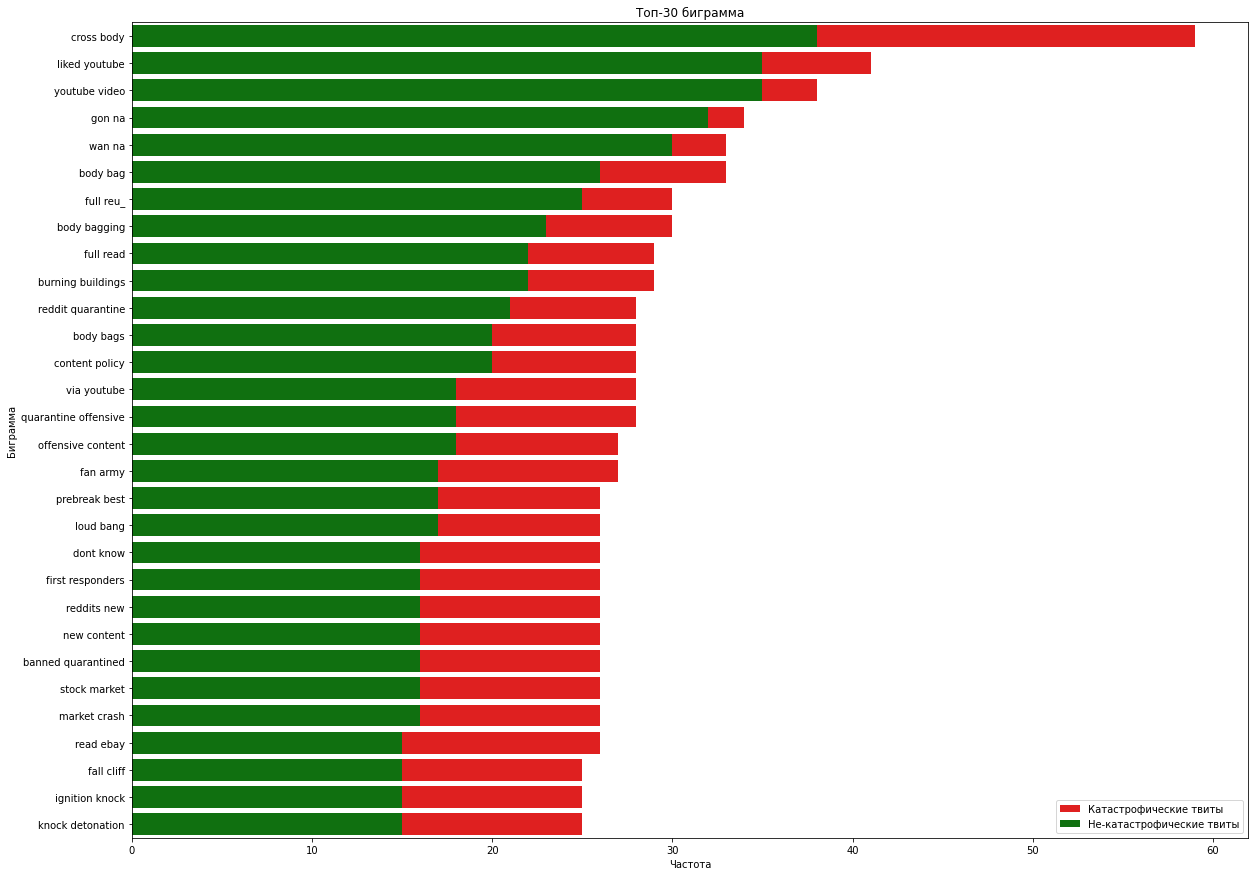

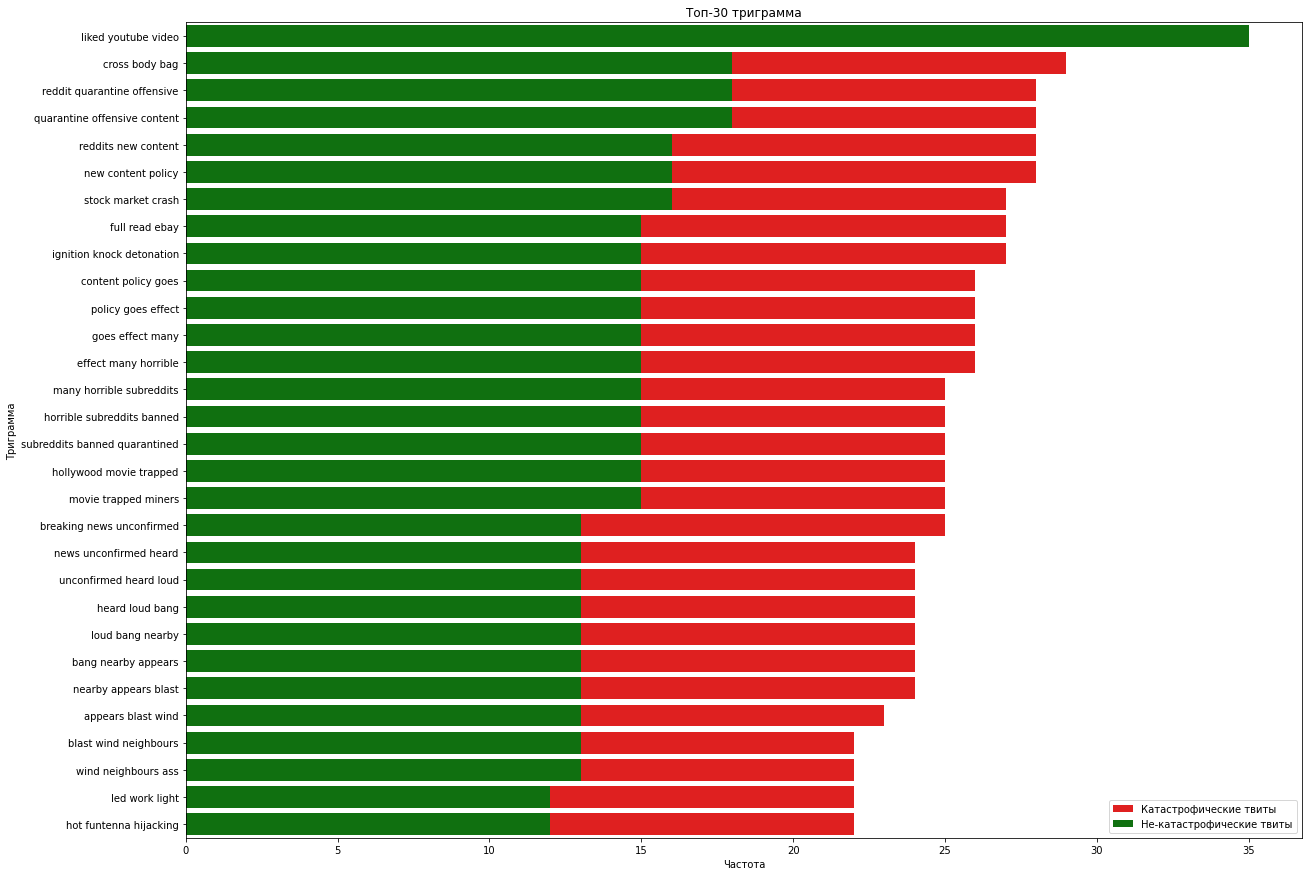

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_ngrams_bar_chart(df_disaster, df_nondisaster, ngram_type):
    plt.figure(figsize=(20, 15))
    sns.barplot(x='Частота', y=ngram_type, data=df_disaster, color='red', label='Катастрофические твиты')
    sns.barplot(x='Частота', y=ngram_type, data=df_nondisaster, color='green', label='Не-катастрофические твиты')
    plt.xlabel('Частота')
    plt.ylabel(ngram_type)
    plt.title(f'Топ-30 {ngram_type.lower()}')
    plt.legend()
    plt.show()

plot_ngrams_bar_chart(df_disaster_unigrams, df_nondisaster_unigrams, 'Униграмма')

plot_ngrams_bar_chart(df_disaster_bigrams, df_nondisaster_bigrams, 'Биграмма')

plot_ngrams_bar_chart(df_disaster_trigrams, df_nondisaster_trigrams, 'Триграмма')


In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [88]:
tokenizer('Поставьте 5 по матану и диффурам нуууууууууууу пожааааааааааааалуйстааааааааа')

{'input_ids': [101, 1194, 14150, 29747, 22919, 10260, 25529, 23742, 22919, 15290, 1019, 1194, 14150, 1191, 10260, 22919, 28995, 29748, 1188, 1184, 10325, 29749, 29749, 29748, 16856, 10260, 29745, 1192, 29748, 29748, 29748, 29748, 29748, 29748, 29748, 29748, 29748, 29748, 29748, 29748, 1194, 14150, 29743, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 29436, 29748, 10325, 29747, 22919, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 10260, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**CONVERSION OF OUR TEXT DATA INTO BERT INPUT FORMAT:**

In [86]:
max_length = max([len(x.split()) for x in df_train.text])
print("Максимальная длина твита:", max_length)

Максимальная длина твита: 24


In [25]:
x_train = tokenizer(
    text=df_train.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [26]:
x_train['input_ids'].shape

TensorShape([7613, 36])

In [27]:
x_train['attention_mask'].shape

TensorShape([7613, 36])

In [85]:
if x_train['input_ids'].shape == x_train['attention_mask'].shape:
    print('Размеры input_ids и attention_mask совпадают.')

Размеры input_ids и attention_mask совпадают.


In [29]:
y_train = df_train.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [30]:
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from transformers import BertTokenizer, TFBertModel

batch_size = 32  
num_epochs = 20

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

embeddings = bert_model(input_ids, attention_mask=input_mask)[1] 
embeddings = Dropout(0.1)(embeddings)

dense_1 = Dense(128, activation='relu')(embeddings)
dense_1 = Dropout(0.1)(dense_1)
dense_2 = Dense(32, activation='relu')(dense_1)

output = Dense(1, activation='sigmoid')(dense_2)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)

for layer in model.layers[2].layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


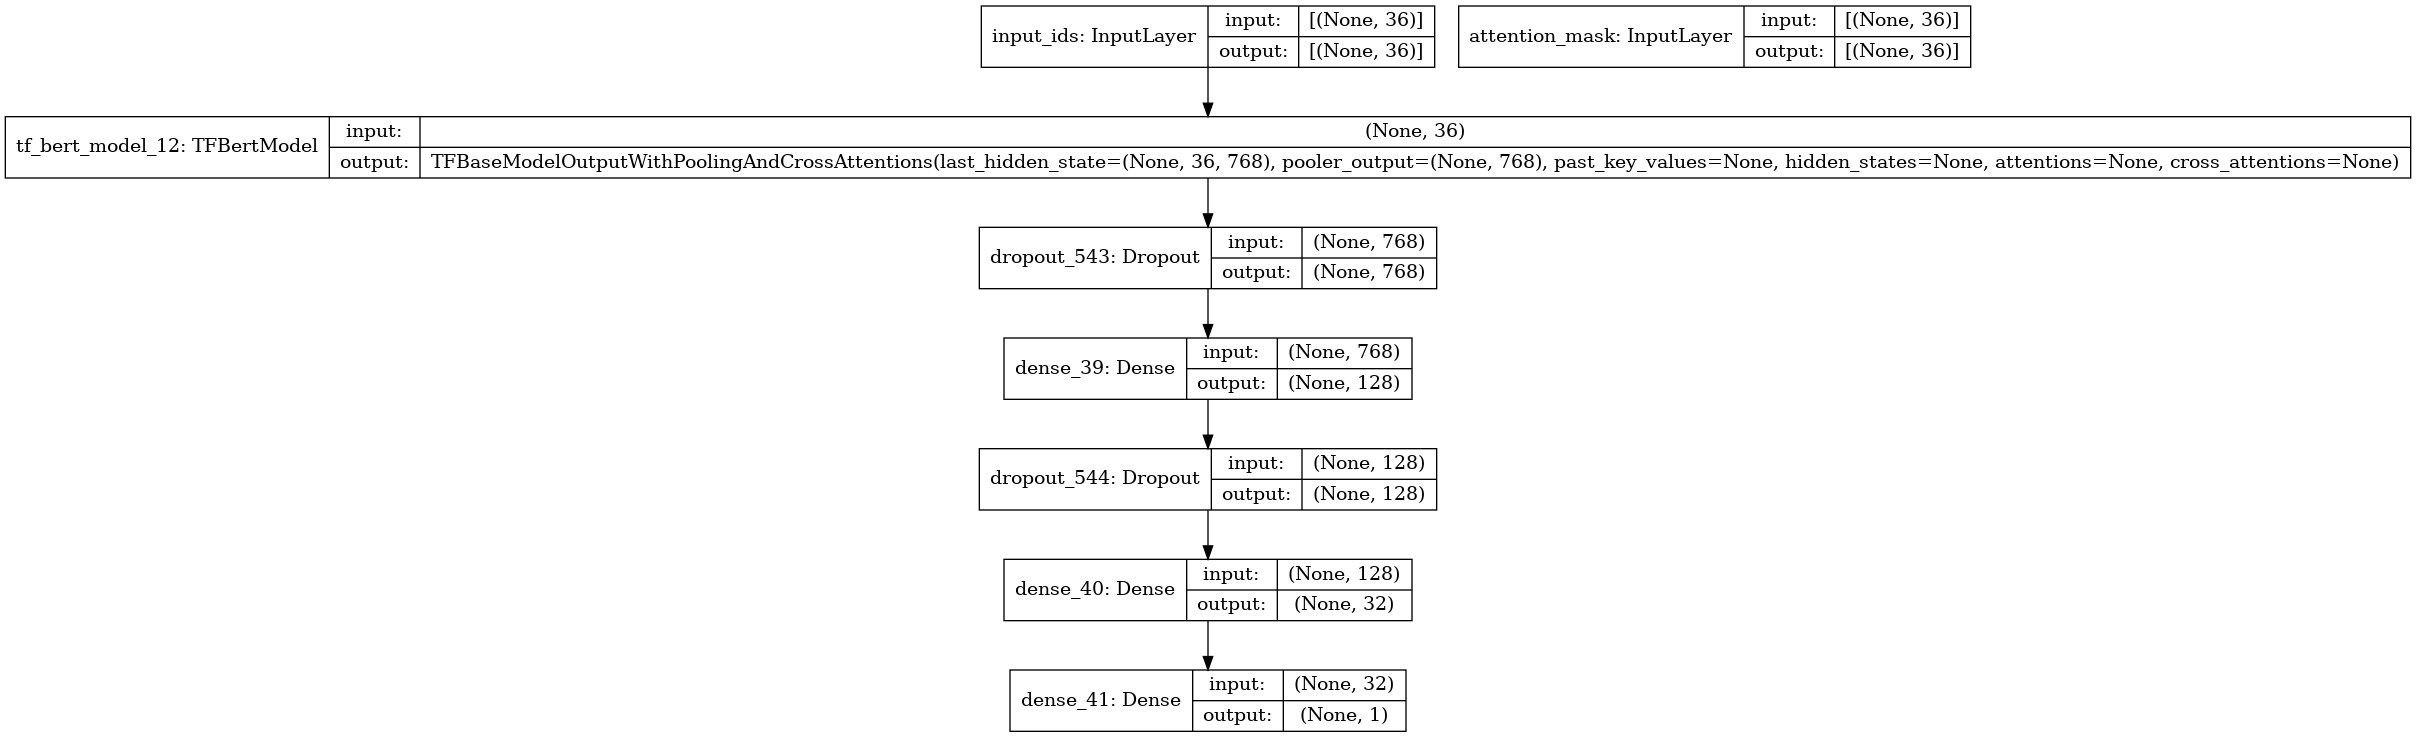

In [83]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [48]:
optimizer = Adam(
    learning_rate=6e-06,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


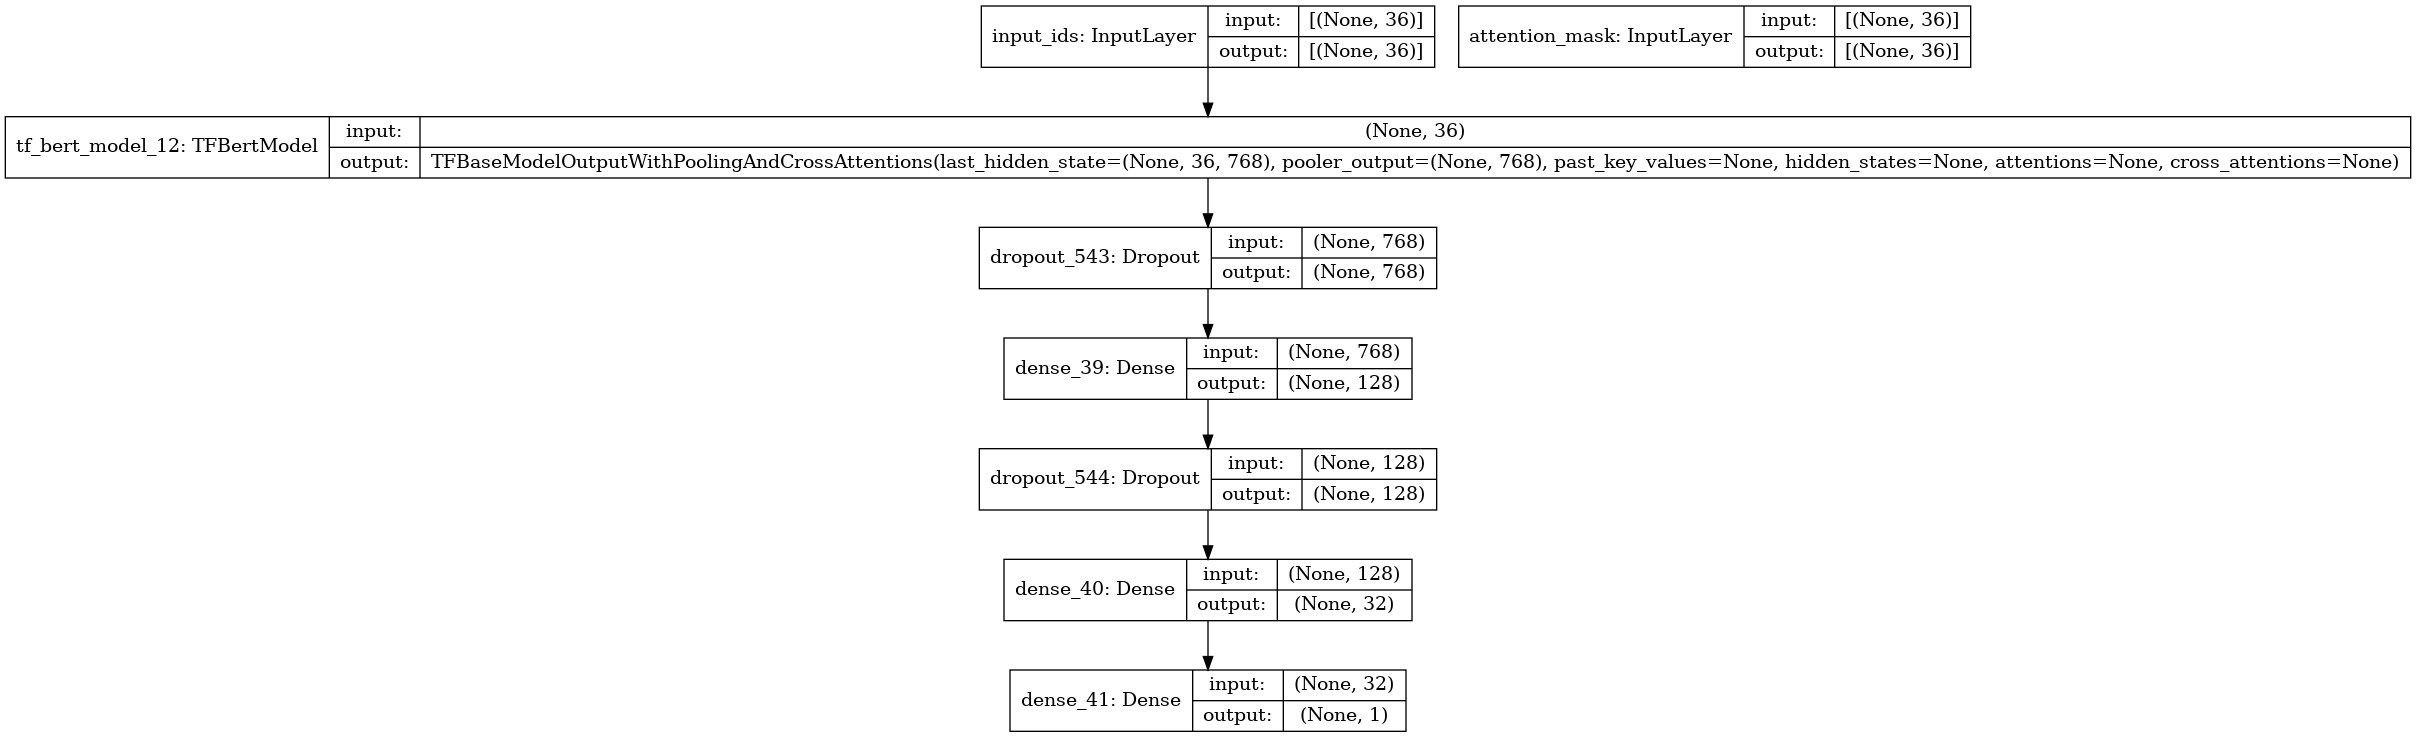

In [49]:
plot_model(model, show_shapes = True)

In [54]:
class IntermediateResults(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0: 
            print('-'*50)
            print("Epoch:", epoch)
            print("Training Loss:", logs['loss'])
            print("Training Accuracy:", logs['accuracy'])
            print('-'*50)

final = model.fit(
    x={'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    y=y_train,
    epochs=9,
    batch_size=10,
    callbacks=[IntermediateResults()] 
)

Epoch 1/9
762/762 [==============================] - 68s 89ms/step - loss: 0.4212 - accuracy: 0.8237
--------------------------------------------------
Epoch: 0
Training Loss: 0.42117419838905334
Training Accuracy: 0.8237226009368896
--------------------------------------------------
Epoch 2/9
762/762 [==============================] - 68s 89ms/step - loss: 0.4141 - accuracy: 0.8286
Epoch 3/9
762/762 [==============================] - 68s 89ms/step - loss: 0.4104 - accuracy: 0.8287
Epoch 4/9
762/762 [==============================] - 68s 89ms/step - loss: 0.4074 - accuracy: 0.8319
Epoch 5/9
762/762 [==============================] - 68s 89ms/step - loss: 0.4007 - accuracy: 0.8367
Epoch 6/9
762/762 [==============================] - 68s 89ms/step - loss: 0.3996 - accuracy: 0.8369
--------------------------------------------------
Epoch: 5
Training Loss: 0.3996390998363495
Training Accuracy: 0.8368580341339111
--------------------------------------------------
Epoch 7/9
762/762 [========

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']
    epochs = np.arange(1, len(loss) + 1)
    
    plt.figure(figsize=(15, 9))  
    
    plt.plot(epochs, acc, color='red', label='Точность') 
    plt.plot(epochs, loss, color='blue', linestyle='--', label='Потери') 
    
    plt.title('Визуализация кривой потерь и точности') 
    plt.xlabel('Эпохи')  
    plt.ylabel('Значение')  
    plt.legend() 
    
    plt.grid(True)  
    plt.tight_layout()  
    
    plt.show()


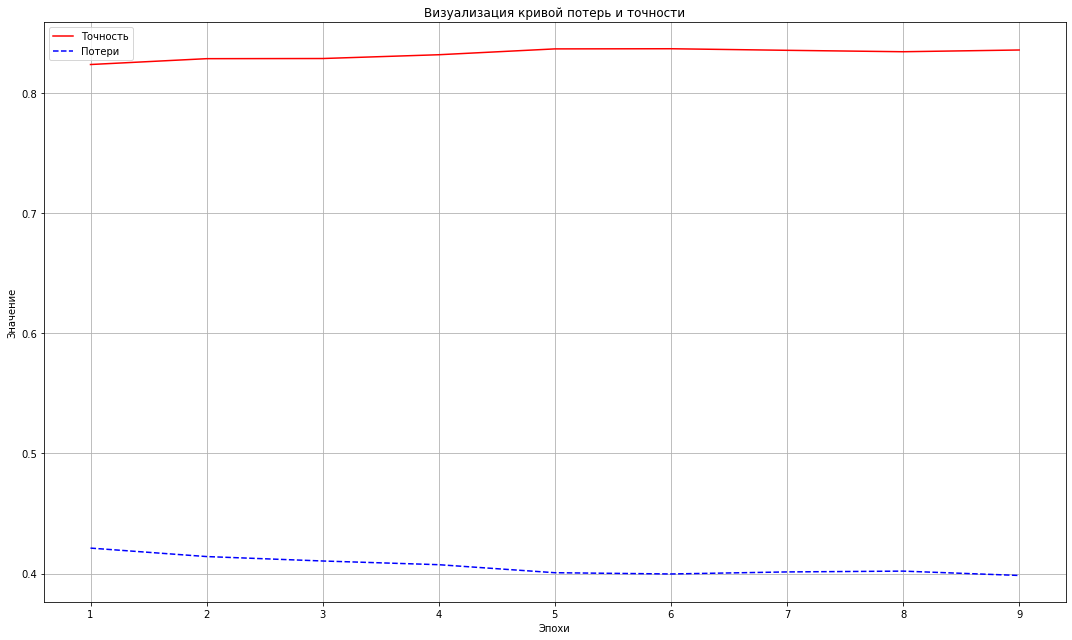

In [78]:
visual_accuracy_and_loss(final)

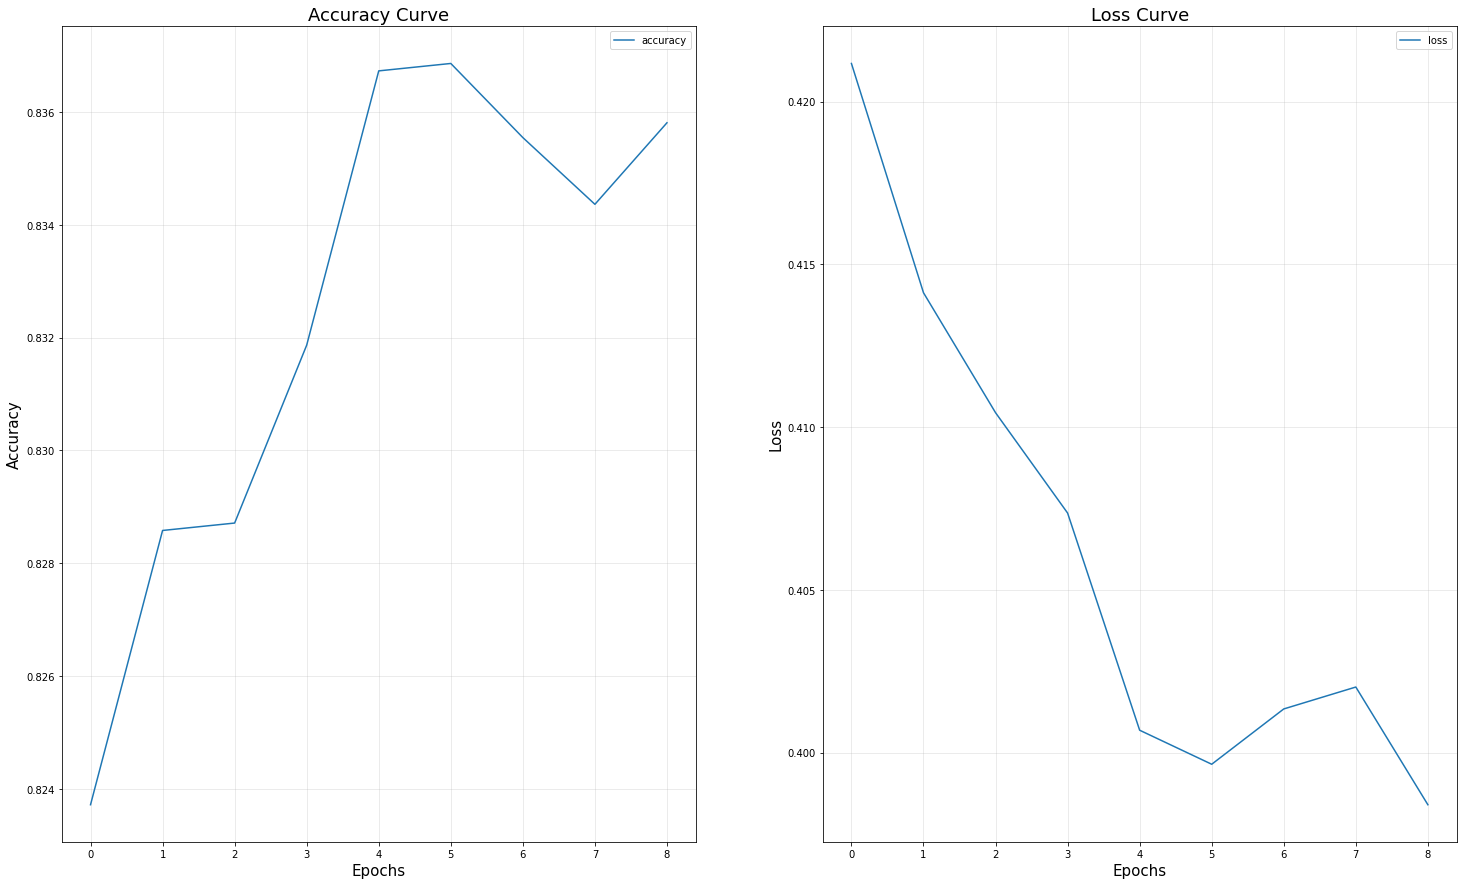

In [80]:
f = plt.figure(figsize=(25,15))

f.add_subplot(121)

plt.plot(final.epoch,final.history['accuracy'],label = "accuracy") 

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

f.add_subplot(122)

plt.plot(final.epoch,final.history['loss'],label="loss") 

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()


In [62]:
df_test

,id,keyword,location,text,message_len,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,0,NaN,NaN,Just happened a terrible car crash,6,6,6,2,0,4.833333,34,0,0,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",9,9,9,2,0,6.222222,64,3,1,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",19,19,19,10,0,4.105263,96,2,0,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,4,4,4,0,0,9.250000,40,3,2,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8,8,8,2,0,4.750000,45,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,8,8,7,0,0,6.000000,55,0,0,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,23,23,22,7,0,5.086957,139,5,0,0
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,6,6,6,1,1,8.333333,55,5,0,0
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,7,7,7,0,1,8.428571,65,7,0,0


In [64]:
x_test = tokenizer(
    text=df_test.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [65]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [66]:
y_predicted = np.where(predicted>0.5,1,0)

In [67]:
y_predicted = y_predicted.reshape((1,3263))[0]

In [70]:
sample_data = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [71]:
sample_data['id'] = df_test.id
sample_data['target'] = y_predicted

In [74]:
sample_data.head(20)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [101]:
sample_data.to_csv('submission.csv',index = False)
print("Успешно завершено! ")

Успешно завершено! 
